# 2_models: Demand Modeling & Price‐Response Grid

This notebook will:
1. Load processed slot‐level data  
2. Perform slot‐level clustering  
3. Train demand‐prediction models (baseline & GBMs)  
4. Generate and save price‐response grid  


In [4]:
# 2.0 Parameters & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import lightgbm as lgb
import catboost as cb
import optuna

# explainability
import shap

In [5]:
PATH = "/Users/arvindpuri/Clays_LondonLAB_Project/data/processed/"

## Data Loading & Validation

In [16]:
# load slot-level file
booking_db = pd.read_parquet(PATH + "booking_master_db.parquet")

booking_db.head()

,Venue Name,month_for,day_of_week_for,search_hour_for,booking_count
0,Birmingham,12,0,18,1
1,Birmingham,12,2,21,1
2,Birmingham,12,4,20,1
3,Birmingham,12,5,13,1
4,Canary Wharf,1,5,13,1


## Get List of Venues

In [19]:
# Get unique venues
venues = booking_db['Venue Name'].unique()
print(f"Venues to analyze: {venues}")
print(f"Number of venues: {len(venues)}")

Venues to analyze: ['Birmingham' 'Canary Wharf' 'The City']
Number of venues: 3


## Loop Through Each Venue

In [21]:
# Store results for all venues
venue_results = {}

# Process each venue
for venue in venues:
    print(f"\n{'='*50}")
    print(f"Processing: {venue}")
    print(f"{'='*50}")
    
    # Filter for specific venue
    venue_data = booking_db[booking_db['Venue Name'] == venue].copy()
    
    # Create pivot table
    booking_pivot = venue_data.pivot_table(
        values='booking_count',
        index=['search_hour_for', 'month_for'],
        columns='day_of_week_for',
        fill_value=0
    )
    
    print(f"Pivot table shape: {booking_pivot.shape}")
    
    # Create feature matrix
    feature_matrix = booking_pivot.copy()
    
    # Add aggregated features
    feature_matrix['total_weekly_bookings'] = feature_matrix.sum(axis=1)
    feature_matrix['weekday_avg'] = feature_matrix.iloc[:, :5].mean(axis=1)  # Mon-Fri
    feature_matrix['weekend_avg'] = feature_matrix.iloc[:, 5:7].mean(axis=1)  # Sat-Sun
    feature_matrix['weekday_weekend_ratio'] = feature_matrix['weekday_avg'] / (feature_matrix['weekend_avg'] + 1)
    
    # Add time-based features
    hours = [idx[0] for idx in feature_matrix.index]
    months = [idx[1] for idx in feature_matrix.index]
    
    feature_matrix['hour_sin'] = np.sin(2 * np.pi * np.array(hours) / 24)
    feature_matrix['hour_cos'] = np.cos(2 * np.pi * np.array(hours) / 24)
    feature_matrix['month_sin'] = np.sin(2 * np.pi * np.array(months) / 12)
    feature_matrix['month_cos'] = np.cos(2 * np.pi * np.array(months) / 12)
    
    # Add business logic features
    feature_matrix['is_business_hour'] = np.array([(8 <= h <= 17) for h in hours]).astype(int)
    feature_matrix['is_lunch_hour'] = np.array([(11 <= h <= 14) for h in hours]).astype(int)
    
    print(f"Final feature matrix shape: {feature_matrix.shape}")
    
    # Store in results
    venue_results[venue] = {
        'features': feature_matrix,
        'pivot': booking_pivot,
        'venue_data': venue_data
    }


Processing: Birmingham
Pivot table shape: (4, 4)
Final feature matrix shape: (4, 14)

Processing: Canary Wharf
Pivot table shape: (95, 7)
Final feature matrix shape: (95, 17)

Processing: The City
Pivot table shape: (104, 7)
Final feature matrix shape: (104, 17)


## Find Optimal K for Each Venue


Finding optimal k for: Birmingham
Number of samples: 4
Testing k values from 2 to 3


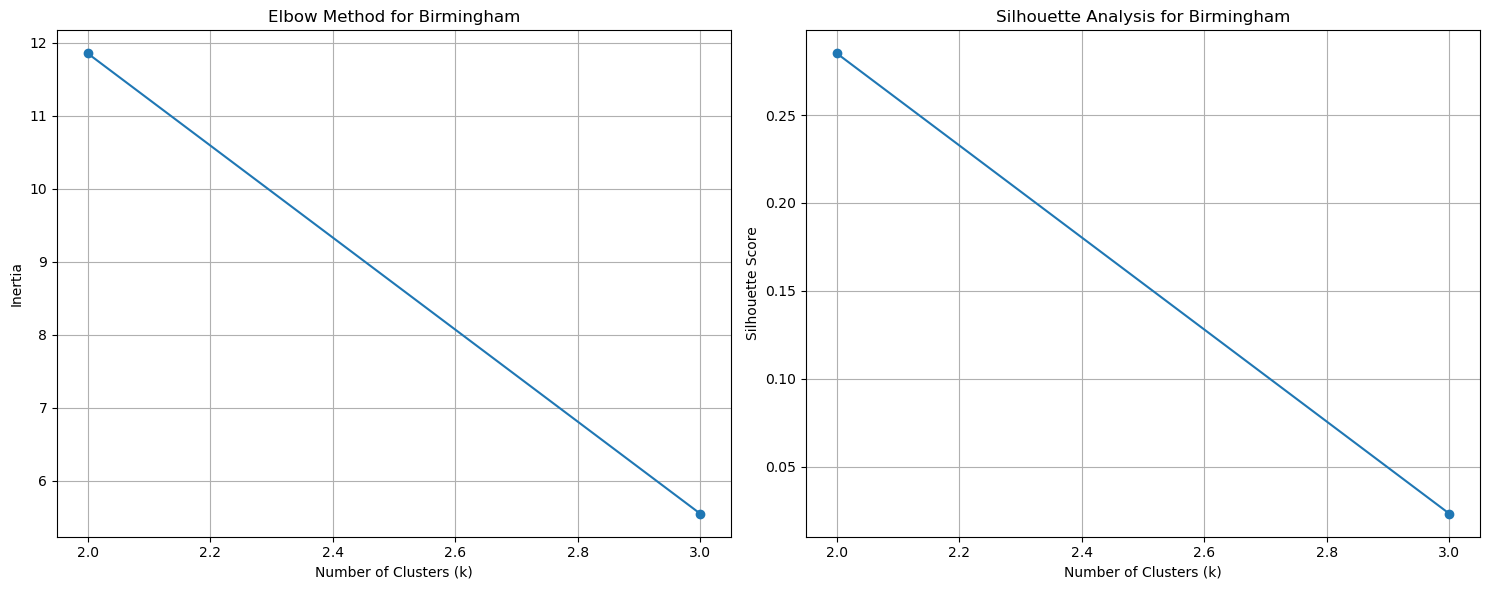


Finding optimal k for: Canary Wharf
Number of samples: 95
Testing k values from 2 to 8


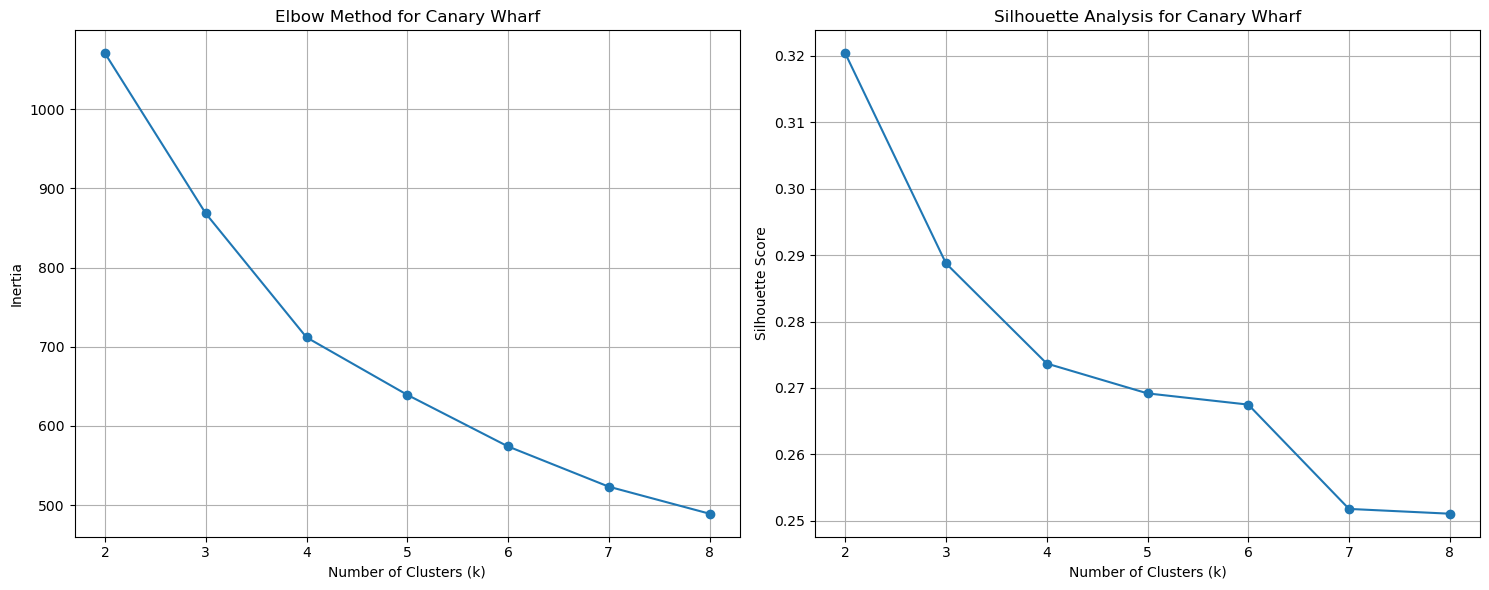


Finding optimal k for: The City
Number of samples: 104
Testing k values from 2 to 8


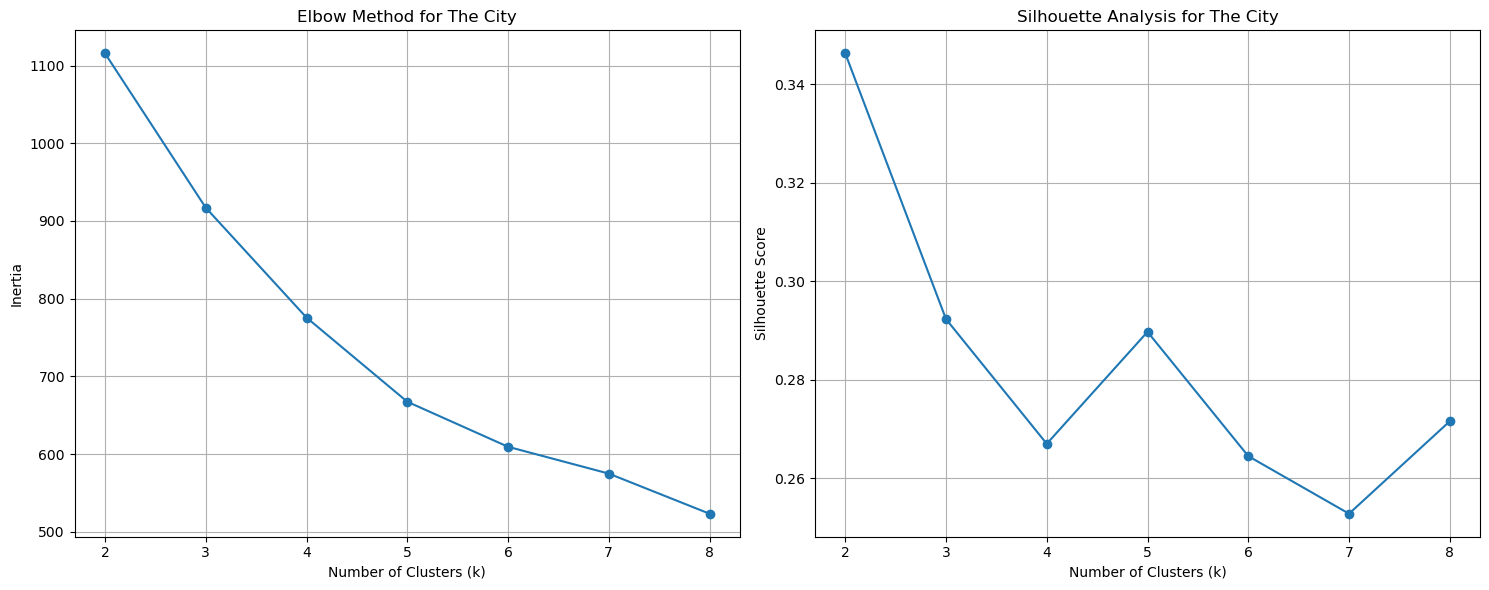

In [27]:
# Find optimal k for each venue
for venue, results in venue_results.items():
    print(f"\n{'='*50}")
    print(f"Finding optimal k for: {venue}")
    print(f"{'='*50}")
    
    feature_matrix = results['features']
    
    # Fix: Convert all column names to strings
    feature_matrix.columns = feature_matrix.columns.astype(str)
    
    # Check if we have enough samples for clustering
    n_samples = len(feature_matrix)
    print(f"Number of samples: {n_samples}")
    
    if n_samples < 4:
        print(f"WARNING: {venue} has only {n_samples} samples. Skipping clustering.")
        results['warning'] = f"Too few samples ({n_samples}) for clustering"
        continue
    
    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(feature_matrix)
    
    # Adjust k_range based on sample size
    max_k = min(8, n_samples - 1)  # k must be less than n_samples
    k_range = range(2, max_k + 1)
    
    print(f"Testing k values from 2 to {max_k}")
    
    inertias = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(features_scaled)
        inertias.append(kmeans.inertia_)
        
        # Only calculate silhouette score if k < n_samples
        if k < n_samples:
            silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))
        else:
            silhouette_scores.append(np.nan)
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    ax1.plot(k_range, inertias, marker='o')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title(f'Elbow Method for {venue}')
    ax1.grid(True)
    
    # Plot silhouette scores (excluding NaN values)
    valid_scores = [(k, s) for k, s in zip(k_range, silhouette_scores) if not np.isnan(s)]
    if valid_scores:
        valid_k, valid_scores = zip(*valid_scores)
        ax2.plot(valid_k, valid_scores, marker='o')
    
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title(f'Silhouette Analysis for {venue}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Store scaler and metrics for later use
    results['scaler'] = scaler
    results['features_scaled'] = features_scaled
    results['k_metrics'] = {
        'k_range': k_range,
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'max_k': max_k
    }

## Set Optimal K and Apply Final Clustering

In [39]:
# Based on your analysis, set optimal k for each venue
venue_optimal_k = {
    'Birmingham': 2,      # Only 4 samples, limited data
    'Canary Wharf': 3,    # Good balance based on both methods
    'The City': 5         # More granular clustering for complex patterns
}

# Apply final clustering with optimal k for each venue
final_venue_results = {}

for venue, results in venue_results.items():
    print(f"\n{'='*50}")
    print(f"Final clustering for: {venue}")
    print(f"{'='*50}")
    
    # Skip venues with warnings
    if 'warning' in results:
        print(f"Skipping {venue}: {results['warning']}")
        continue
    
    # Get optimal k for this venue
    optimal_k = venue_optimal_k.get(venue, 3)  # Default to 3 if not specified
    print(f"Using k = {optimal_k}")
    
    # Get scaled features
    features_scaled = results['features_scaled']
    
    # Fit final model
    final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = final_kmeans.fit_predict(features_scaled)
    
    # Add cluster labels to feature matrix
    feature_matrix = results['features'].copy()
    feature_matrix['cluster'] = cluster_labels
    
    # Analyze clusters
    cluster_summary = feature_matrix.groupby('cluster').agg({
        'total_weekly_bookings': ['mean', 'min', 'max'],
        'weekday_avg': 'mean',
        'weekend_avg': 'mean',
        'weekday_weekend_ratio': 'mean'
    })
    
    print(cluster_summary)
    
    # Store final results
    final_venue_results[venue] = {
        'model': final_kmeans,
        'clustered_features': feature_matrix,
        'cluster_summary': cluster_summary,
        'optimal_k': optimal_k
    }


Final clustering for: Birmingham
Using k = 2
day_of_week_for total_weekly_bookings           weekday_avg weekend_avg  \
                                 mean  min  max        mean        mean   
cluster                                                                   
0                                 1.0  1.0  1.0         0.4         0.4   
1                                 1.0  1.0  1.0         0.4         0.4   

day_of_week_for weekday_weekend_ratio  
                                 mean  
cluster                                
0                            0.285714  
1                            0.285714  

Final clustering for: Canary Wharf
Using k = 3
day_of_week_for total_weekly_bookings              weekday_avg weekend_avg  \
                                 mean   min    max        mean        mean   
cluster                                                                      
0                            8.641509   1.0   53.0    0.909434    2.047170   
1                 

## Assign Meaningful Names to Clusters

In [41]:
# Assign names to clusters based on booking patterns
for venue, results in final_venue_results.items():
    print(f"\n{'='*50}")
    print(f"Assigning cluster names for: {venue}")
    print(f"{'='*50}")
    
    feature_matrix = results['clustered_features']
    
    # Analyze cluster characteristics
    cluster_characteristics = feature_matrix.groupby('cluster').agg({
        'total_weekly_bookings': 'mean'
    }).sort_values('total_weekly_bookings', ascending=False)
    
    print("Cluster characteristics (sorted by booking volume):")
    print(cluster_characteristics)
    
    # Assign names based on booking volume and venue
    n_clusters = len(cluster_characteristics)
    cluster_names = {}
    
    if venue == 'Birmingham':
        # For Birmingham with k=2
        cluster_names = {
            cluster_characteristics.index[0]: 'Peak',
            cluster_characteristics.index[1]: 'Off-Peak'
        }
    elif venue == 'Canary Wharf':
        # For Canary Wharf with k=3
        cluster_names = {
            cluster_characteristics.index[0]: 'Peak',
            cluster_characteristics.index[1]: 'Normal',
            cluster_characteristics.index[2]: 'Low Traffic'
        }
    elif venue == 'The City':
        # For The City with k=5
        cluster_names = {
            cluster_characteristics.index[0]: 'Super Peak',
            cluster_characteristics.index[1]: 'Peak',
            cluster_characteristics.index[2]: 'Normal Peak',
            cluster_characteristics.index[3]: 'Moderate',
            cluster_characteristics.index[4]: 'Low Traffic'
        }
    
    # Apply cluster names
    feature_matrix['cluster_name'] = feature_matrix['cluster'].map(cluster_names)
    
    print(f"\nCluster names: {cluster_names}")
    
    # Update the results
    results['cluster_names'] = cluster_names
    results['clustered_features'] = feature_matrix


Assigning cluster names for: Birmingham
Cluster characteristics (sorted by booking volume):
day_of_week_for  total_weekly_bookings
cluster                               
0                                  1.0
1                                  1.0

Cluster names: {0: 'Peak', 1: 'Off-Peak'}

Assigning cluster names for: Canary Wharf
Cluster characteristics (sorted by booking volume):
day_of_week_for  total_weekly_bookings
cluster                               
1                           108.100000
2                            77.454545
0                             8.641509

Cluster names: {1: 'Peak', 2: 'Normal', 0: 'Low Traffic'}

Assigning cluster names for: The City
Cluster characteristics (sorted by booking volume):
day_of_week_for  total_weekly_bookings
cluster                               
1                           147.333333
2                            88.785714
4                            71.875000
3                             8.736842
0                             6.32

## Add Cluster Assignments to booking_db

In [43]:
# Now add cluster assignments to booking_db
# First, create a comprehensive mapping of all cluster assignments
all_cluster_assignments = []

for venue, results in final_venue_results.items():
    cf = results['clustered_features']
    cluster_names = results['cluster_names']
    
    # Extract hour and month from the index and create assignments
    for idx in cf.index:
        hour, month = idx  # Assuming index is (hour, month)
        cluster = cf.loc[idx, 'cluster']
        cluster_name = cluster_names.get(cluster, f'Cluster_{cluster}')
        
        assignment = {
            'Venue Name': venue,
            'search_hour_for': hour,
            'month_for': month,
            'cluster': cluster,
            'cluster_name': cluster_name
        }
        all_cluster_assignments.append(assignment)

# Convert to DataFrame
cluster_assignments_df = pd.DataFrame(all_cluster_assignments)

# Merge with booking_db
booking_db_with_clusters = booking_db.merge(
    cluster_assignments_df,
    on=['Venue Name', 'search_hour_for', 'month_for'],
    how='left'
)

# Check results
print("Cluster assignment summary:")
summary = booking_db_with_clusters.groupby('Venue Name').agg({
    'cluster': 'count',
    'cluster_name': 'count'
}).rename(columns={'cluster': 'total_records', 'cluster_name': 'records_with_clusters'})
print(summary)

# Show sample results
print("\nSample of booking_db with clusters:")
sample_data = booking_db_with_clusters.groupby('Venue Name').head(3)
print(sample_data[['Venue Name', 'search_hour_for', 'day_of_week_for', 'month_for', 'booking_count', 'cluster', 'cluster_name']])

Cluster assignment summary:
              total_records  records_with_clusters
Venue Name                                        
Birmingham                4                      4
Canary Wharf            389                    389
The City                413                    413

Sample of booking_db with clusters:
       Venue Name  search_hour_for  day_of_week_for  month_for  booking_count  \
0      Birmingham               18                0         12              1   
1      Birmingham               21                2         12              1   
2      Birmingham               20                4         12              1   
4    Canary Wharf               13                5          1              1   
5    Canary Wharf               13                5          3              1   
6    Canary Wharf               17                5          3              4   
393      The City               14                5          1              1   
394      The City               

## Verify Cluster Assignments

In [58]:
# Verify cluster assignments by checking coverage
print("=== Cluster Assignment Verification ===")

for venue in venues:
    print(f"\n{venue}:")
    venue_data = booking_db_with_clusters[booking_db_with_clusters['Venue Name'] == venue]
    
    total_records = len(venue_data)
    records_with_clusters = venue_data['cluster'].notna().sum()
    coverage = (records_with_clusters / total_records) * 100 if total_records > 0 else 0
    
    print(f"  Total records: {total_records}")
    print(f"  Records with clusters: {records_with_clusters}")
    print(f"  Coverage: {coverage:.1f}%")
    
    # Show cluster distribution
    if records_with_clusters > 0:
        cluster_dist = venue_data['cluster_name'].value_counts()
        print(f"  Cluster distribution:")
        for cluster, count in cluster_dist.items():
            pct = (count / records_with_clusters) * 100
            print(f"    {cluster}: {count} ({pct:.1f}%)")
    
    # Check for missing combinations
    if coverage < 100:
        missing_data = venue_data[venue_data['cluster'].isna()]
        missing_combinations = missing_data[['search_hour_for', 'month_for']].drop_duplicates()
        print(f"  Missing combinations: {len(missing_combinations)}")
        if len(missing_combinations) > 0:
            print(f"  Sample missing: {missing_combinations.head().values.tolist()}")

=== Cluster Assignment Verification ===

Birmingham:
  Total records: 4
  Records with clusters: 4
  Coverage: 100.0%
  Cluster distribution:
    Peak: 3 (75.0%)
    Off-Peak: 1 (25.0%)

Canary Wharf:
  Total records: 389
  Records with clusters: 389
  Coverage: 100.0%
  Cluster distribution:
    Normal: 135 (34.7%)
    Peak: 132 (33.9%)
    Low Traffic: 122 (31.4%)

The City:
  Total records: 413
  Records with clusters: 413
  Coverage: 100.0%
  Cluster distribution:
    Super Peak: 102 (24.7%)
    Normal Peak: 97 (23.5%)
    Peak: 84 (20.3%)
    Low Traffic: 82 (19.9%)
    Moderate: 48 (11.6%)


In [60]:
booking_db_with_clusters.to_parquet(PATH + "booking_master_db.parquet")